In [2]:
import sys
print(sys.path)
sys.path.append('../Data_Feature')
sys.path.append('../Datasets')
import numpy as np
import os
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB # or GaussianNB if your data is normalized and continuous
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, make_scorer, matthews_corrcoef
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import zipfile
from bioservices import KEGG
from K_func import translate_ko_terms


'''
Data prep and feature mapping
'''

os.chdir('../Datasets')
# Paths to your uploaded files
zip_file_path_KO = 'terms_KO.zip'
csv_file_name_KO = 'terms_KO.csv'
zip_file_path_traits = 'reducedDataset.zip'
csv_file_name_traits = 'reducedDataset.csv'

# Read and preprocess KO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='KO', values='value', fill_value=0)

# Apply VarianceThreshold to remove constant features
selector = VarianceThreshold(threshold=0.01)
X_filtered = selector.fit_transform(X_terms)
X_filtered_df = pd.DataFrame(X_filtered, index=X_terms.index, columns=X_terms.columns[selector.get_support()])

# Optionally, inspect the variance of features to confirm removal
feature_variances = X_filtered_df.var()
print(f"Features with zero variance after filtering: {sum(feature_variances == 0)}")

# Read and preprocess traits data
with zipfile.ZipFile(zip_file_path_traits, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_traits) as file:
        traits = pd.read_csv(file, sep=';')
traits['oxygen'] = traits['oxygen'].str.lower()

# Mapping of oxygen levels to a simplified classification
oxygen_mapping = {
    'aerobic': 'aerobic',
    'aerotolerant': 'aerobic',
    'microaerophilic': 'aerobic',
    'obligate aerobic': 'aerobic',
    'anaerobic': 'anaerobic',
    'obligate anaerobic': 'anaerobic',
    'conflict': 'aerobic',  
    'facultative': 'aerobic'  
}
traits['oxygen'] = traits['oxygen'].map(oxygen_mapping)

# Handling missing values and aggregating by key
y = traits.dropna(subset=['oxygen']).groupby('key').agg({'oxygen': lambda x: x.value_counts().index[0]})

# Find common keys after removing missing values
common_keys = X_filtered_df.index.intersection(y.index)

# Align X (features) and Y (labels) based on common keys
X_aligned = X_filtered_df.loc[common_keys]
Y_aligned = y.loc[common_keys].values.ravel()

# Ensures X_aligned and Y_aligned are aligned
assert X_aligned.shape[0] == len(Y_aligned), "X and Y are not aligned"



['c:\\Users\\eliah\\Documents\\Master\\Eliah-Masters\\KOs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.752.0_x64__qbz5n2kfra8p0\\python312.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.752.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.752.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.752.0_x64__qbz5n2kfra8p0', '', 'C:\\Users\\eliah\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages', 'C:\\Users\\eliah\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\win32', 'C:\\Users\\eliah\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\win32\\lib', 'C:\\Users\\eliah\\AppData\

KO   K00001  K00002  K00003  K00004  K00005  K00007  K00008  K00009  K00010  \
key                                                                           
1       0.0     0.0     1.0     0.0     0.0     0.0     1.0     0.0     0.0   
2       1.0     0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0   
3       1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4       1.0     0.0     1.0     0.0     0.0     0.0     1.0     0.0     0.0   
5       0.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0   

KO   K00011  ...  K22477  K22478  K22479  K22486  K22489  K22491  K22502  \
key          ...                                                           
1       0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2       0.0  ...     0.0     0.0     0.0     0.0     0.0     1.0     0.0   
3       0.0  ...     0.0     0.0     0.0     0.0     0.0     1.0     0.0   
4       0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0  

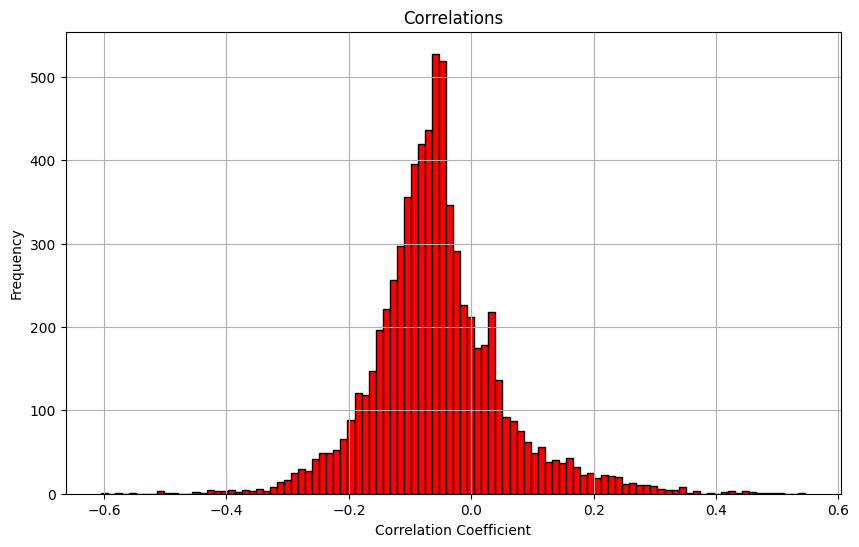

In [3]:
''' Calculating Pearsons coefficient'''

# Always look at data, right?
print(X_aligned.head())



'''Handelig data values'''

# Checking datatype for y_algned, i think
class_distribution = pd.Series(Y_aligned).value_counts()
print("Class distribution in Y_aligned:", class_distribution)

# Checks data label of Y algined
unique_labels = np.unique(Y_aligned)
print(f"Unique labels in Y_aligned: {unique_labels}")

# Initialize the LabelEncoder and transform the data from catagorical
label_encoder = LabelEncoder()
Y_aligned = label_encoder.fit_transform(Y_aligned)

# Check data once labelencoder is done
print(f"Data of Y_aligned: {np.unique(Y_aligned)}")


# Calculate Pearson correlation coefficients
corr_coefficients = [] # Collectes coefficents from X_aligned and Y_aligned calculations

# I should probably check how pearsons actually works


for column in X_aligned.columns: # Iterates over every column in X_aligned
    # Easier to check all the different collumns because its a pandas data frame
    # Interger indexing is cool but i dont like it
    r, p = pearsonr(X_aligned[column], Y_aligned)  
    corr_coefficients.append(r)


# PLotting
plt.figure(figsize=(10, 6))
plt.hist(corr_coefficients, bins=100, color='red', edgecolor='black')
plt.title('Correlations')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()




Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found: {'estimator': RandomForestClassifier(random_state=42), 'estimator__max_depth': 5, 'estimator__n_estimators': 100, 'select_k__k': 1}
Best cross-validation score: 0.886
Matthews Correlation Coefficient: 0.6144474152233103


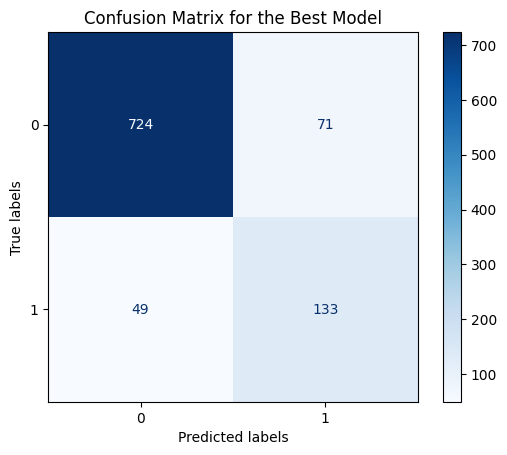

In [6]:
''' Pipeline implementation for Naive bayes and random forests'''

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_aligned, Y_aligned, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ('select_k', SelectKBest(f_classif)),
    ('estimator', RandomForestClassifier())
])

# Define a parameter grid to search over
param_grid = [
    {
        'select_k__k': [1],  # May need adjusting  100, 200, 300
        'estimator': [RandomForestClassifier(random_state=42)],
        'estimator__n_estimators': [100, 200],  
        'estimator__max_depth': [5, 10, None]  
    },
    {
        'select_k__k': [1],  # May need as needed  100, 200, 300
        'estimator': [SVC(random_state=42)],
        'estimator__C': [0.1, 1, 10],  
        'estimator__kernel': ['linear', 'rbf'], 
        'estimator__gamma': ['scale', 'auto']  
    },
    {
        'select_k__k' : [1],
        'estimator': [LogisticRegression()],
        'estimator__C': [0.01, 0.1, 1, 10, 100]
    },         
    {
        'select_k__k': [1],  
        'estimator': [BernoulliNB()],
        'estimator__alpha': [0.01, 0.1, 1.0, 10.0],  
        'estimator__binarize': [0.0]  # Is automatically applied
    }
]



''' Grid search '''

# Set up GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, Y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)


'''MCC shenanigans'''

mcc = matthews_corrcoef(Y_test, Y_pred)
print(f"Matthews Correlation Coefficient: {mcc}")


# Display confusion matrix for the best model
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix for the Best Model')
plt.show()



Most selected KO terms for predicting oxygen trait in hierchical manner (F score):
Index(['K01589', 'K00164', 'K01772', 'K05919', 'K01599', 'K00254', 'K02259',
       'K04070', 'K02257', 'K01163'],
      dtype='object', name='KO')


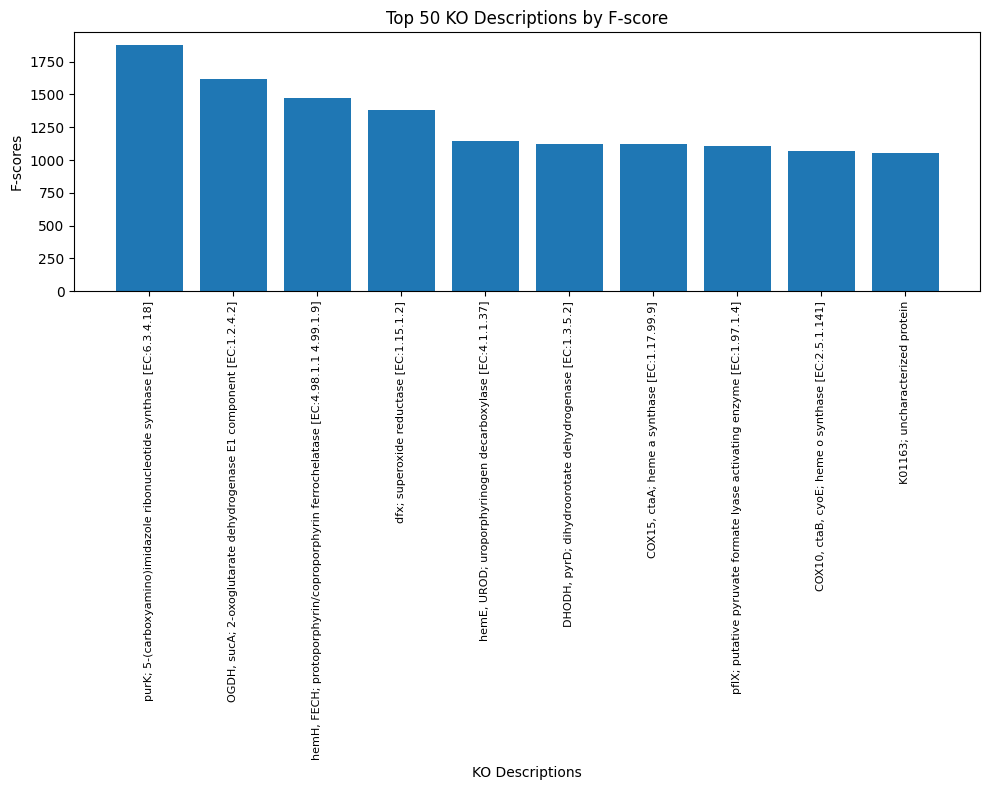

In [ ]:
''' Finding best traits '''

# Finding most predictive features with respect to target value (oxygen)
select_k_best = SelectKBest(f_classif, k=10)  
X_new = select_k_best.fit_transform(X_aligned, Y_aligned)
selected_features = select_k_best.get_support(indices=True)

# Get the names of the selected KO terms
selected_ko_terms = X_aligned.columns[selected_features]

# Fitting select K best to find the scores
select_k_best.fit(X_aligned, Y_aligned)
scores = select_k_best.scores_[selected_features] # scores of selected features

# Sorting features by their scores
sorted_indices = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_indices]
sorted_features = selected_ko_terms[sorted_indices]

print("Most selected KO terms for predicting oxygen trait in hierchical manner (F score):")
print(sorted_features)

''' Plot for visualizing distribution and importance of best traits'''

# Translate selected KO terms to their descriptions
selected_ko_terms_list = list(sorted_features)  
ko_descriptions_mapping = translate_ko_terms(selected_ko_terms_list)


# Replace KO terms with their descriptions for plotting
translated_sorted_features = [ko_descriptions_mapping[ko] for ko in sorted_features]

# Plotting with translated names
plt.figure(figsize=(10, 8))
plt.bar(range(len(translated_sorted_features)), sorted_scores)
plt.xticks(range(len(translated_sorted_features)), translated_sorted_features, rotation='vertical', fontsize=8)
plt.xlabel('KO Descriptions')
plt.ylabel('F-scores')
plt.title('Top 50 KO Descriptions by F-score')
plt.tight_layout()
plt.show()


In [8]:

''' TROUBLE SHOOTING '''

# Check the distribution of classes in Y_train
class_distribution = pd.Series(Y_train).value_counts()
print("Class distribution in Y_train:\n", class_distribution)

# Check unique labels in Y_train
unique_labels = np.unique(Y_train)
print(f"Unique labels in Y_train: {unique_labels}")


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform Y_train to encode labels
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Replace Y_train with the encoded labels if necessary
Y_train = Y_train_encoded

# Now, you can inspect the unique values of the encoded Y_train
print(f"Unique encoded labels in Y_train: {np.unique(Y_train)}")


# Check if the number of instances matches
print(f"Number of instances in X_train: {X_train.shape[0]}")
print(f"Number of labels in Y_train: {len(Y_train)}")

Class distribution in Y_train:
 0    1909
1     370
Name: count, dtype: int64
Unique labels in Y_train: [0 1]
Unique encoded labels in Y_train: [0 1]
Number of instances in X_train: 2279
Number of labels in Y_train: 2279


In [9]:
''' K values versus f1 score plot'''


# Define the range of `k` values to explore
k_values = range(1, 3000, 100)  # Range of steps

# Define estimators to compare
estimators = {
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SupportVectorMachines' : SVC(),
    'LogisticRegression' : LogisticRegression(),
    'BernoulliNB': BernoulliNB()
}

# Prepare to store results
results = {name: [] for name in estimators}

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5)

# Loop over each estimator
for name, estimator in estimators.items():
    print(f"Processing estimator: {name}")  # Debug print
    # Loop over each `k` value
    for k in k_values:
        print(f"Testing with k={k}")  # Debug print
        # Define the pipeline for the current estimator
        pipeline = Pipeline([
            ('select_k', SelectKBest(f_classif, k=k)),
            ('estimator', estimator)
        ])
        
        # Perform cross-validation using StratifiedKFold
        cv_scores = cross_val_score(pipeline, X_train, Y_train, cv=cv, scoring=make_scorer(f1_score, average='macro'), n_jobs=-1)
        
        # Store the mean F1 score for this `k`
        results[name].append(cv_scores.mean())


# For debugging 
print(results)


Processing estimator: RandomForestClassifier
Testing with k=1
Testing with k=101
Testing with k=201


KeyboardInterrupt: 

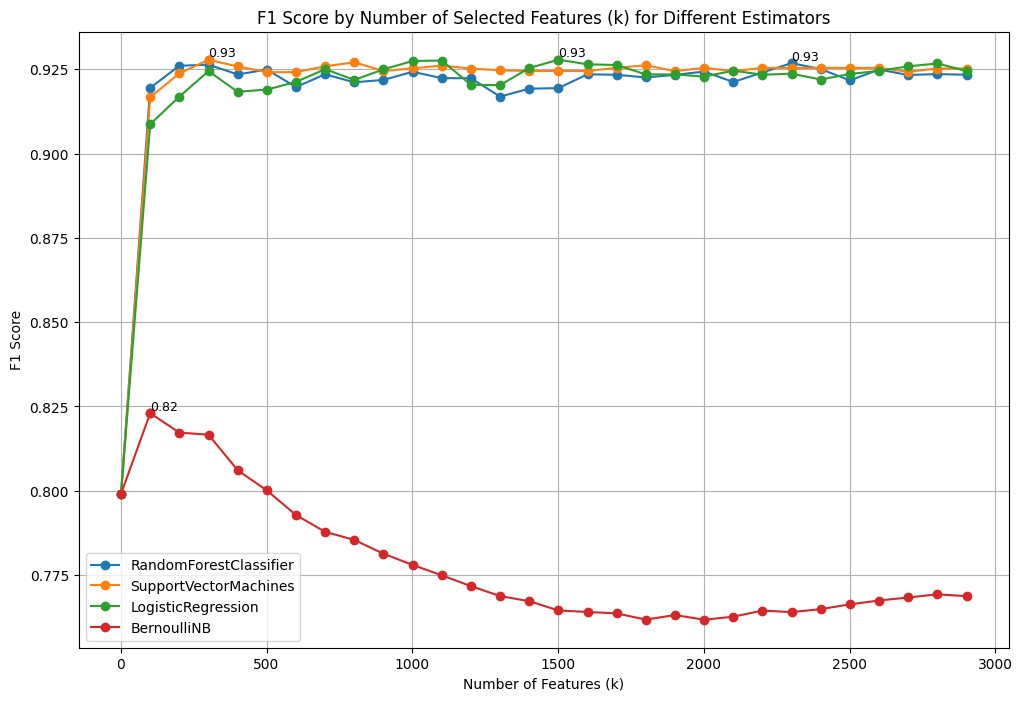

In [ ]:
''' Plot for F1 vs K features '''

# Plotting the results for each estimator
plt.figure(figsize=(12, 8))

for name, scores in results.items():
    k_values_list = list(k_values)  # Convert range to list for indexing

    # Filter out non-finite scores and corresponding k values
    finite_scores = [score for score in scores if np.isfinite(score)]
    finite_k_values = [k for k, score in zip(k_values_list, scores) if np.isfinite(score)]

    if not finite_scores:  # Skips if no finite scores are found
        print(f"No finite scores for {name}, skipping.")
        continue

    max_f1_score_index = finite_scores.index(max(finite_scores))  # Index of the highest F1 score for this estimator
    max_f1_score = finite_scores[max_f1_score_index]  # The highest F1 score
    best_k = finite_k_values[max_f1_score_index]  # `k` value for the highest F1 score

    # Plot F1 scores
    plt.plot(finite_k_values, finite_scores, marker='o', linestyle='-', label=name)
    
    # Highlight the point with the highest F1 score
    plt.scatter([best_k], [max_f1_score], color='red')  # Highlight with red color
    if np.isfinite(max_f1_score) and np.isfinite(best_k):  # Ensures finite
        plt.text(best_k, max_f1_score, f"{max_f1_score:.2f}", fontsize=9, verticalalignment='bottom')

plt.title('F1 Score by Number of Selected Features (k) for Different Estimators')
plt.xlabel('Number of Features (k)')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Initialize and fit SelectKBest with k=1
selector = SelectKBest(score_func=f_classif, k=1)
selector.fit(X_train, Y_train)

# Get the boolean mask of the selected feature
selected_mask = selector.get_support()

# Apply the mask to the list of feature names to get the selected feature's name
selected_feature = [column for (column, is_selected) in zip(X_train.columns, selected_mask) if is_selected]

print(f"Feature for K=1 is:", translate_ko_terms({selected_feature[0]}))


Feature for K=1 is: {'K01589': 'purK; 5-(carboxyamino)imidazole ribonucleotide synthase [EC:6.3.4.18]'}
